In [1]:
from HSmodule import *
from source.SimHashDetection import SimHashDetection
from source.minHashDetection import MinHashDetection
from source.BloomDetection import BloomDetection
from source.FaissSearch import FaissSearch
from source.Preprocessor import *
import numpy as np
import pandas as pd

e:\DSA\Extended_assign\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Đọc và chọn cột (làm lại từ đầu cho chắc)
df_large = pd.read_csv('dataset/dataset_small.csv')
df_large = df_large[['question1', 'question2']]

# 2. Nối 2 cột thành một Series
s = pd.concat([df_large['question1'], df_large['question2']])

# 3. DÙNG .dropna() ĐỂ XÓA TẤT CẢ GIÁ TRỊ RỖNG (NaN)
s_clean = s.dropna()

# 4. Bây giờ mới chuyển thành list
listText = s_clean.tolist()

# Bây giờ listText của bạn sẽ sạch và chỉ chứa chuỗi

In [3]:
model1 = BloomDetection()
model2 = MinHashDetection()
model3 = SimHashDetection()
listModel = [model1, model2, model3]
model_names = ['BloomDetection', 'MinHashDetection', 'SimHashDetection']

In [7]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import gc  # <--- THÊM THƯ VIỆN GARBAGE COLLECTOR

# ==============================================================================
# 1. KHAI BÁO MODEL VÀ DỮ LIỆU
# (Giả định bạn đã import BloomDetection, MinHashDetection, SimHashDetection, listText)
# ==============================================================================

# ==============================================================================
# 2. HÀM HELPER
# (Giữ nguyên)
# ==============================================================================
def get_list_size_mb(text_list: list) -> float:
    """
    Tính toán tổng kích thước bộ nhớ (tính bằng MB) của một danh sách các chuỗi.
    """
    total_bytes = sys.getsizeof(text_list)
    for s in text_list:
        total_bytes += sys.getsizeof(s)
    return total_bytes / (1024 * 1024)

# ==============================================================================
# 3. ĐO BỘ NHỚ KHỞI TẠO
# (Giữ nguyên)
# ==============================================================================

print("Đo lường bộ nhớ khởi tạo của Model (Init Memory)...")

# Hàm bọc (wrapper)
def init_model(model_class):
    return model_class()

# Đo lường
baseline_before_all = memory_usage()[0]
mem_usage_bloom = memory_usage((init_model, (BloomDetection,)), max_usage=True)
init_mem_bloom = mem_usage_bloom - baseline_before_all
# ... (Giống code cũ, đo cho MinHash và SimHash) ...
mem_usage_minhash = memory_usage((init_model, (MinHashDetection,)), max_usage=True)
init_mem_minhash = mem_usage_minhash - baseline_before_all
mem_usage_simhash = memory_usage((init_model, (SimHashDetection,)), max_usage=True)
init_mem_simhash = mem_usage_simhash - baseline_before_all

model_init_memory = {
    'BloomDetection': init_mem_bloom,
    'MinHashDetection': init_mem_minhash,
    'SimHashDetection': init_mem_simhash,
}
print(f"  - BloomDetection Init: {init_mem_bloom:.2f} MiB")
print(f"  - MinHashDetection Init: {init_mem_minhash:.2f} MiB")
print(f"  - SimHashDetection Init: {init_mem_simhash:.2f} MiB")

# Khởi tạo các model để sử dụng
print("\nKhởi tạo các model để chạy thử nghiệm...")
model1 = BloomDetection()
model2 = MinHashDetection()
model3 = SimHashDetection()
listModel = [model1, model2, model3]
model_names = ['BloomDetection', 'MinHashDetection', 'SimHashDetection']

print(f"Sử dụng {len(listText)} văn bản có sẵn.")

# ==============================================================================
# 4. CHẠY THỬ NGHIỆM VÀ ĐO LƯỜNG (ĐÃ CẬP NHẬT CHỐNG NHIỄU)
# ==============================================================================

results_list = []
num_steps = 5
# SỐ LẦN CHẠY ĐỂ LẤY TRUNG VỊ (Càng cao càng mượt nhưng càng chậm)
num_runs_per_step = 1
# Sửa lại range của bạn, tôi nhớ bạn muốn 1000 -> 10000
amounts_to_test = np.linspace(10000, 50000, num_steps, dtype=int)

print(f"\nBắt đầu đo lường trên {num_steps} bước (từ 1000 đến 10000)...")
print(f"Mỗi bước sẽ chạy {num_runs_per_step} lần để lấy trung vị (chống nhiễu).")

for amount in amounts_to_test:
    print(f"\n--- Đang xử lý {amount} văn bản ---")
    sub_list = listText[:amount]
    input_mb = get_list_size_mb(sub_list)
    
    for model, name in zip(listModel, model_names):
        print(f"  Đo lường Model: {name} (chạy {num_runs_per_step} lần)...")
        
        # Danh sách để lưu kết quả của N lần chạy
        run_increments = []
        
        for i in range(num_runs_per_step):
            try:
                # === GIẢI PHÁP 1: KIỂM SOÁT GARBAGE COLLECTOR ===
                gc.collect()  # 1. Dọn dẹp sạch trước khi đo
                gc.disable()  # 2. Tắt GC để nó không chạy ngẫu nhiên
                
                # Chạy đo lường
                mem_readings_tuple = memory_usage(
                    (model.detect, (sub_list,)),
                    interval=0.01,
                    timeout=120,
                    retval=True,
                    max_usage=False
                )
                
                gc.enable()  # 3. Bật lại GC sau khi đo xong

                # === Hết phần kiểm soát GC ===
                
                mem_readings = mem_readings_tuple[0]
                
                if not mem_readings:
                    print(f"    Lần chạy {i+1} LỖI: Không thể đo lường.")
                    continue
                    
                # Tính toán mức tăng
                peak_mem = max(mem_readings)
                baseline_mem = mem_readings[0]
                mem_increment = peak_mem - baseline_mem
                
                # Thêm vào danh sách để lấy trung vị
                run_increments.append(mem_increment)

            except Exception as e:
                gc.enable() # Đảm bảo GC được bật lại nếu có lỗi
                print(f"    Lần chạy {i+1} LỖI: {e}")
        
        # === GIẢI PHÁP 2: LẤY TRUNG VỊ (MEDIAN) ===
        if not run_increments:
            print(f"    LỖI: Tất cả {num_runs_per_step} lần chạy cho {name} đều thất bại.")
            continue
        
        # Tính trung vị của các mức tăng
        median_increment = np.median(run_increments)
        
        # Tính tổng bộ nhớ (Init + Median)
        init_memory = model_init_memory[name]
        total_memory_used = init_memory + median_increment
        
        # 3. Lưu kết quả
        results_list.append({
            'Model': name,
            'Amount': amount,
            'Input (MB)': input_mb,
            'Memory (MiB)': total_memory_used
        })
        
        print(f"    -> Input: {input_mb:.2f} MB, "
              f"Init: {init_memory:.2f} MiB, "
              f"Detect Incr (Median): {median_increment:.2f} MiB, "
              f"Tổng: {total_memory_used:.2f} MiB")

# ==============================================================================
# 5. VẼ BIỂU ĐỒ ĐƯỜNG
# (Giữ nguyên)
# ==============================================================================

print("\nTính toán hoàn tất. Đang vẽ biểu đồ...")
df_results = pd.DataFrame(results_list)

if df_results.empty:
    print("Không có dữ liệu để vẽ.")
else:
    print("\n--- Kết quả đo lường (5 dòng đầu) ---")
    print(df_results.head())

    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.set_title("So sánh Tổng Sử dụng Bộ nhớ của các Model", fontsize=16)
    ax.set_xlabel("Kích thước Input (MB)", fontsize=12)
    ax.set_ylabel("Tổng Bộ nhớ Sử dụng (Init + Peak) (MiB)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    for name in model_names:
        model_df = df_results[df_results['Model'] == name]
        if not model_df.empty:
            model_df = model_df.sort_values(by='Input (MB)')
            ax.plot(
                model_df['Input (MB)'], 
                model_df['Memory (MiB)'], 
                marker='o', 
                markersize=5, 
                label=name
            )

    ax.legend(title="Model")
    plt.tight_layout()
    print("\nHiển thị biểu đồ. Đóng cửa sổ biểu đồ để kết thúc.")
    plt.show()

print("Hoàn tất.")

Đo lường bộ nhớ khởi tạo của Model (Init Memory)...


KeyboardInterrupt: 


Tính toán hoàn tất. Đang vẽ biểu đồ...

--- Kết quả đo lường (5 dòng đầu) ---
               Model  Amount  Input (MB)  Memory (MiB)
0     BloomDetection   10000    1.043468     89.824219
1   MinHashDetection   10000    1.043468     15.894531
2   SimHashDetection   10000    1.043468     23.300781
3     BloomDetection   20000    2.087183    208.710938
4   MinHashDetection   20000    2.087183     40.101562
5   SimHashDetection   20000    2.087183     76.796875
6     BloomDetection   30000    3.129382    324.988281
7   MinHashDetection   30000    3.129382     60.261719
8   SimHashDetection   30000    3.129382    150.656250
9     BloomDetection   40000    4.169014    407.937500
10  MinHashDetection   40000    4.169014     88.089844
11  SimHashDetection   40000    4.169014    217.148438
12    BloomDetection   50000    5.217784    463.046875
13  MinHashDetection   50000    5.217784    107.691406
14  SimHashDetection   50000    5.217784    294.667969

Hiển thị biểu đồ. Đóng cửa sổ biểu đồ để

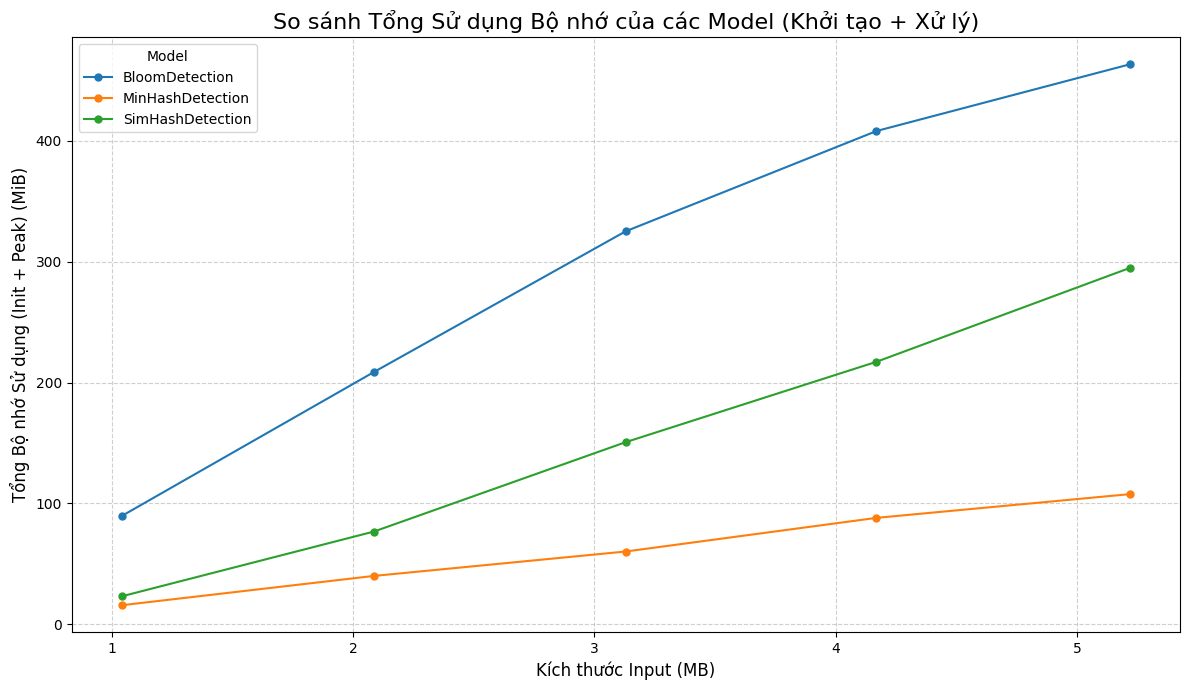

Hoàn tất.


In [8]:
# ==============================================================================
# 5. VẼ BIỂU ĐỒ ĐƯỜNG
# ==============================================================================

print("\nTính toán hoàn tất. Đang vẽ biểu đồ...")
df_results = pd.DataFrame(results_list)

if df_results.empty:
    print("Không có dữ liệu để vẽ. Đã xảy ra lỗi trong quá trình đo lường.")
else:
    print("\n--- Kết quả đo lường (5 dòng đầu) ---")
    print(df_results.head(30))

    # Khởi tạo figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Cập nhật tiêu đề và trục Y
    ax.set_title("So sánh Tổng Sử dụng Bộ nhớ của các Model (Khởi tạo + Xử lý)", fontsize=16)
    # Trục X là Kích thước Input (MB)
    ax.set_xlabel("Kích thước Input (MB)", fontsize=12)
    # Trục Y là TỔNG bộ nhớ (MiB)
    ax.set_ylabel("Tổng Bộ nhớ Sử dụng (Init + Peak) (MiB)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Vẽ từng đường cho mỗi model
    for name in model_names:
        model_df = df_results[df_results['Model'] == name]
        if not model_df.empty:
            # Sắp xếp theo Input (MB) để đảm bảo đường vẽ đúng
            model_df = model_df.sort_values(by='Input (MB)')
            ax.plot(
                model_df['Input (MB)'], 
                model_df['Memory (MiB)'], 
                marker='o', 
                markersize=5, 
                label=name
            )

    ax.legend(title="Model")
    plt.tight_layout()
    
    # Hiển thị biểu đồ
    print("\nHiển thị biểu đồ. Đóng cửa sổ biểu đồ để kết thúc.")
    plt.show()

print("Hoàn tất.")